In [2]:
import math
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [3]:
sales = pd.read_csv('~/projects/video-game-sales-by-maturity-rating/Video_Games_Sales_as_at_22_Dec_2016.csv')

In [41]:
sales['Year_of_Release'].unique()

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000.,   nan, 1995., 1991., 1981., 1987.,
       1980., 1983., 2020., 2017.])

In [34]:
na_sales_not_m = sales[sales['Rating'] != 'M']
na_sales_m = sales[sales['Rating'] == 'M']

(array([1398.,   95.,   32.,   14.,    8.,    4.,    8.,    2.,    0.,
           2.]),
 array([1.0000e-02, 2.1130e+00, 4.2160e+00, 6.3190e+00, 8.4220e+00,
        1.0525e+01, 1.2628e+01, 1.4731e+01, 1.6834e+01, 1.8937e+01,
        2.1040e+01]),
 <a list of 10 Patch objects>)

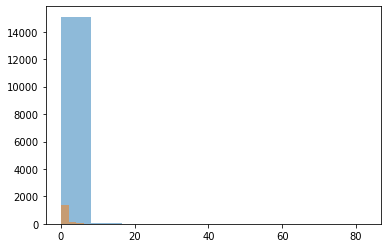

In [35]:
#na_sales_t_rpg = na_sales_t[na_sales_t['Genre'].isin(['Role-Playing'])].nlargest(162, 'Global_Sales')
#na_sales_m_rpg = na_sales_m[na_sales_m['Genre'].isin(['Role-Playing'])]

plt.hist(na_sales_not_m['Global_Sales'], alpha=0.5)
plt.hist(na_sales_m['Global_Sales'], alpha=0.5)

In [38]:
stats.describe(na_sales_m['Global_Sales'])

DescribeResult(nobs=1563, minmax=(0.01, 21.04), mean=0.9429558541266794, variance=3.7125824225057196, skewness=5.001289542210704, kurtosis=32.83379898864777)

In [22]:
na_sales_m_rpg['NA_Sales'].describe()

count    162.000000
mean       0.468765
std        0.810856
min        0.000000
25%        0.022500
50%        0.135000
75%        0.467500
max        5.050000
Name: NA_Sales, dtype: float64

In [20]:
na_sales_t_rpg.nlargest(162, 'NA_Sales')

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
65,Final Fantasy VII,PS,1997.0,Role-Playing,Sony Computer Entertainment,3.01,2.47,3.28,0.96,9.72,92.0,20.0,9.2,1282.0,SquareSoft,T
84,Final Fantasy X,PS2,2001.0,Role-Playing,Sony Computer Entertainment,2.91,2.07,2.73,0.33,8.05,92.0,53.0,8.7,1056.0,SquareSoft,T
288,World of Warcraft: The Burning Crusade,PC,2007.0,Role-Playing,Activision,2.57,1.52,0.00,0.00,4.09,91.0,46.0,7.9,785.0,Blizzard Entertainment,T
619,Marvel: Ultimate Alliance,X360,2006.0,Role-Playing,Activision,2.29,0.02,0.00,0.19,2.50,82.0,68.0,7.5,120.0,Raven Software,T
88,Final Fantasy VIII,PS,1999.0,Role-Playing,SquareSoft,2.28,1.72,3.63,0.23,7.86,90.0,24.0,8.6,644.0,SquareSoft,T
508,The Elder Scrolls III: Morrowind,XB,2002.0,Role-Playing,Ubisoft,2.09,0.63,0.03,0.11,2.86,87.0,34.0,8.7,111.0,Bethesda Softworks,T
177,Final Fantasy X-2,PS2,2003.0,Role-Playing,Electronic Arts,1.92,1.08,2.11,0.17,5.29,85.0,45.0,6.6,400.0,SquareSoft,T
148,Final Fantasy XII,PS2,2006.0,Role-Playing,Square Enix,1.88,0.00,2.33,1.74,5.95,92.0,64.0,7.6,972.0,Square Enix,T
800,World of Warcraft: Cataclysm,PC,2010.0,Role-Playing,Activision,1.77,0.32,0.00,0.00,2.08,90.0,53.0,5.6,953.0,Blizzard Entertainment,T
173,Final Fantasy XIII,PS3,2009.0,Role-Playing,Square Enix,1.74,1.21,1.87,0.51,5.33,83.0,83.0,7.3,2483.0,Square Enix,T
